In [25]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

import statsmodels.api as sm

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

import seaborn as sns
from scipy import stats
from scipy.stats import truncnorm
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

import warnings
import os
from copy import deepcopy

import plotting
import dataset_fctns
import modelling_fctns

#from  pydynpd import regression

from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor, RandomForestRegressor, GradientBoostingClassifier
from sklearn.inspection import permutation_importance
import plotting
import dataset_fctns

In [26]:
def make_cumulative(ds, driver_variable = 'tas', numdays = 200, T_base = 0):
    ds.loc[:, [f'{driver_variable} at day {n}' for n in range(numdays)]] = (np.maximum(ds.loc[:, [f'{driver_variable} at day {n}' for n in range(numdays)]] - T_base, 0)).cumsum(axis = 1)
    return ds

Get an indexing column and time indexing column.

In [3]:
def get_progressions_from_data(srs, temp_variable = 't2m', NDVI_skip = 56, numsteps = 183):
    return np.array([[srs['year'], srs['Stations_id'], n, srs[f'NDVI interpolated at day {NDVI_skip + n}'], srs[f'{temp_variable} at day {n}'], srs[f'photoperiod at day {NDVI_skip + n}'], srs[f'dev stage at day {n}']] for n in range(numsteps)])

In [63]:
ds_inputs_SSA.columns.to_list()#

['Unnamed: 0.1',
 'Unnamed: 0',
 'year',
 'Stations_id',
 'Day of start',
 'NDVI interpolated at day 0',
 'NDVI interpolated at day 8',
 'NDVI interpolated at day 16',
 'NDVI interpolated at day 24',
 'NDVI interpolated at day 32',
 'NDVI interpolated at day 40',
 'NDVI interpolated at day 48',
 'NDVI interpolated at day 56',
 'NDVI interpolated at day 64',
 'NDVI interpolated at day 72',
 'NDVI interpolated at day 80',
 'NDVI interpolated at day 88',
 'NDVI interpolated at day 96',
 'NDVI interpolated at day 104',
 'NDVI interpolated at day 112',
 'NDVI interpolated at day 120',
 'NDVI interpolated at day 128',
 'NDVI interpolated at day 136',
 'NDVI interpolated at day 144',
 'NDVI interpolated at day 152',
 'NDVI interpolated at day 160',
 'NDVI interpolated at day 168',
 'NDVI interpolated at day 176',
 'NDVI interpolated at day 184',
 'NDVI interpolated at day 192',
 'NDVI interpolated at day 200',
 'NDVI interpolated at day 208',
 'NDVI interpolated at day 216',
 'NDVI interpolat

In [ ]:
def get_progressions_from_data_climate(srs, NDVI_skip = 56, numsteps = 183, response_name = 'DTF'):
    #print(len())
    return np.array([srs[['year', 'Stations_id', 'lat', 'lon', f'day {n}'] + [f'{variable_name} at day {n}' for variable_name in ['t2m', 't2min', 't2max', 'vpd', 'tp', 'ssrd', 'photoperiod', response_name]] + ['observed']].to_list() for n in range(numsteps)])
    #print(result.shape)

In [5]:
def get_progressions_from_data_10_step(srs, temp_variable = 't2m', NDVI_skip = 56, numsteps = 153):
    return np.array([[srs['year'], srs['Stations_id'], n] + [srs[f'NDVI interpolated at day {NDVI_skip + n + t}'] for t in range(10)] + [srs[f'{temp_variable} at day {n + t}'] for t in range(10)] + [srs[f'photoperiod at day {NDVI_skip + n + t}'] for t in range(10)] + [srs[f'dev stage at day {n + 9}']] for n in range(numsteps)])

In [ ]:
def convert_data_to_panel(ds, temp_variable = 't2m', NDVI_skip = 56, numsteps = 183, step10 = False, climate = False, response_name = 'DTF'):
    for point_index in range(len(ds)):
        if step10:
            arr_point = get_progressions_from_data_10_step(ds.iloc[point_index], temp_variable=temp_variable, NDVI_skip = NDVI_skip, numsteps = numsteps)
            ds_point = pd.DataFrame(arr_point, columns=['year', 'Stations_id', 'time from SOS'] + 
                                                       [f'NDVI at t minus {9 - t}' for t in range(10)] + 
                                                       [f'acc temp at t minus {9 - t}' for t in range(10)] +
                                                       [f'photoperiod at t minus {9 - t}' for t in range(10)] +
                                                       ['dev stage'])
        elif climate:
            arr_point = get_progressions_from_data_climate(ds.iloc[point_index], NDVI_skip = NDVI_skip, numsteps = numsteps, response_name=response_name)
            ds_point = pd.DataFrame(arr_point, columns=['year', 'Stations_id', 'lat', 'lon', 'time from SOS'] + 
                                                       ['t2m', 't2min', 't2max', 'vpd', 'tp', 'ssrd', 'photoperiod', response_name, 'observed'])
        else:
            arr_point = get_progressions_from_data(ds.iloc[point_index], temp_variable=temp_variable, NDVI_skip = NDVI_skip, numsteps = numsteps)
            ds_point = pd.DataFrame(arr_point, columns=['year', 'Stations_id', 'time from SOS', 'NDVI', 'acc temp', 'photoperiod', 'dev stage'])
        if point_index == 0:
            ds_panel = ds_point
        else:
            ds_panel = pd.concat([ds_panel, ds_point])
    return ds_panel

In [7]:
def logit_reg(train, predictors = ['NDVI', 'acc temp', 'photoperiod', 'const'], response_type = 'dev stage'):
    Xtrain = train[predictors] #'NDVI', 
    ytrain = train[[response_type]]
    
    # building the model and fitting the data
    if response_type == 'dev stage':
        log_reg = sm.Logit(ytrain, Xtrain).fit()
    elif response_type == 'DTF':
        log_reg = sm.OLS(ytrain, Xtrain).fit()
    return log_reg

In [8]:
def train_test_on_statyear(ds, train_proportion = 0.8, identifying_columns=['Stations_id', 'year']):
    statyear = ds[identifying_columns].drop_duplicates().values
    train_size = int(statyear.shape[0]*train_proportion)
    test_size = statyear.shape[0] - train_size
    row_choices = np.random.choice(np.arange(statyear.shape[0]), size = train_size, replace = False)
    train_statyear = pd.DataFrame(statyear[row_choices, :], columns = identifying_columns)
    test_statyear = pd.DataFrame(np.delete(statyear, row_choices, axis = 0), columns = identifying_columns)
    train = ds.merge(train_statyear, on=identifying_columns, how = 'inner') #.loc[ds[['Stations_id', 'year']].isin(train_statyear)]
    test = ds.merge(test_statyear, on=identifying_columns, how = 'inner')
    return train, test


In [9]:
def anthesis_from_ds(ds, obs_column):
    return ds.loc[ds[obs_column] == 1]['time from SOS'].min()

In [80]:
test.loc[test['fitted'] == 1]#.groupby(['Stations_id', 'year']).apply(anthesis_from_ds, 'fitted', include_groups = False)#['fitted']

,Unnamed: 0,year,Stations_id,lat,lon,time from SOS,t2m,t2min,t2max,vpd,tp,ssrd,photoperiod,DTF,observed time to beginning of flowering,const,dev stage,fitted,observed
0,0,2015.0,7504.0,54.3167,10.0500,0.0,7.682962,278.305700,284.281229,-0.148689,0.006329,9.672460e+06,14.850000,108.0,108.0,1,1,1.0,1
1,1,2015.0,7504.0,54.3167,10.0500,1.0,13.825748,273.930654,283.512596,-0.161263,0.000744,9.927688e+06,14.916667,107.0,108.0,1,1,1.0,1
2,2,2015.0,7504.0,54.3167,10.0500,2.0,22.188961,276.723111,285.710925,-0.189182,0.001112,1.146254e+07,15.000000,106.0,108.0,1,1,1.0,1
3,3,2015.0,7504.0,54.3167,10.0500,3.0,30.728589,279.249518,284.858063,-0.111099,0.013331,9.658667e+06,15.066667,105.0,108.0,1,1,1.0,1
4,4,2015.0,7504.0,54.3167,10.0500,4.0,38.322110,276.832853,284.362859,-0.071412,0.010214,1.080633e+07,15.133333,104.0,108.0,1,1,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459232,82,2011.0,19914.0,50.3168,9.3627,82.0,1320.677143,283.120698,295.065326,-0.153680,0.013170,1.309745e+07,15.866667,0.0,82.0,1,1,1.0,1
459233,83,2011.0,19914.0,50.3168,9.3627,83.0,1335.894247,286.868199,290.763138,-0.046302,0.180555,4.228612e+06,15.833333,-1.0,82.0,1,0,1.0,0
459234,84,2011.0,19914.0,50.3168,9.3627,84.0,1351.816276,286.495417,292.244747,-0.065524,0.071530,8.724037e+06,15.800000,-2.0,82.0,1,0,1.0,0
459235,85,2011.0,19914.0,50.3168,9.3627,85.0,1366.246200,285.111178,290.030470,-0.119293,0.012894,9.150108e+06,15.733333,-3.0,82.0,1,0,1.0,0


In [83]:
def compare_logreg_test(test, log_reg, predictors = ['NDVI', 'acc temp', 'photoperiod', 'const'], response_type = 'dev stage'):
    Xtest = test[predictors] #
    ytest = test[[response_type]]
    #with warnings.catch_warnings(action="ignore"):
    with warnings.catch_warnings():
        Xtest.loc[:, 'fitted'] = log_reg.predict(Xtest).round()
        Xtest.loc[:, 'observed'] = ytest
    try:
        test = test.drop(['fitted', 'observed'], axis = 1).merge(Xtest[['fitted', 'observed']], left_index=True, right_index=True)
    except:
        test = test.merge(Xtest[['fitted', 'observed']], left_index=True, right_index=True)
    if response_type == 'dev stage':
        test_observed = test.groupby(['Stations_id', 'year']).apply(anthesis_from_ds, 'observed', include_groups = False)
        test_fitted = test.groupby(['Stations_id', 'year']).apply(anthesis_from_ds, 'fitted', include_groups = False)
    elif response_type == 'DTF':
        test_observed = test.groupby(['Stations_id', 'year']).apply(prediction_from_frame, 'observed', include_groups = False)
        test_fitted = test.groupby(['Stations_id', 'year']).apply(prediction_from_frame, 'fitted', include_groups = False)
    test_for_regression = pd.concat([test_fitted, test_observed], axis=1).rename(columns = {0: 'fitted', 1: 'observed'})
    return test_for_regression

In [ ]:
def plot_fitted_observed_histogram(test_for_regression, title = 'fitted vs. observed'):
    fig, ax = plt.subplots()
    sns.histplot(x='fitted', data = test_for_regression, ax=ax, label = 'fitted',
                stat = 'density')
    sns.histplot(x='observed', data = test_for_regression, ax=ax, label= 'observed',
                stat = 'density')
    ax.set_xlabel('Days to anthesis')
    ax.set_title(title)
    #ax.plot([minval, maxval], [minval, maxval], linestyle = '--', color='k')
    fig.legend(bbox_to_anchor = (1.2, 0.9))
    rsquared = r2_score(comparison_frame['observed'], comparison_frame['fitted'])
    print(f'R^2 value for model: {rsquared}')
    bias = comparison_frame['observed'].mean() - comparison_frame['fitted'].mean()
    variance_fitted = comparison_frame[f'fitted'].var()
    print(f'Bias: {bias**2}\nVariance of modelled values: {variance_modelled}')

In [12]:
def plot_fitted_observed(test_for_regression, title = 'fitted vs observed'):
    fig, ax = plt.subplots()
    minval = test_for_regression['fitted'].min()
    maxval = test_for_regression['observed'].max()
    sns.regplot(data = test_for_regression, x = 'fitted', y ='observed', ax = ax, 
                scatter_kws={'alpha':0.5, 's':4},  x_bins=np.arange(minval - 5, maxval + 5, 3))
    ax.plot([minval, maxval], [minval, maxval], linestyle = '--', color = 'black')
    r2_score_model = r2_score(test_for_regression['observed'], test_for_regression['fitted'])
    print('R2 score', r2_score_model)
    ax.set_title(title)

In [95]:
ds_panel_DE.loc[ds_panel_DE.isna().any(axis=1)]

,Unnamed: 0,year,Stations_id,lat,lon,time from SOS,t2m,t2min,t2max,vpd,tp,ssrd,photoperiod,DTF,observed time to beginning of flowering,const,dev stage


In [100]:
def KFold_crossval(ds, k_folds, predictors = ['NDVI', 'acc temp', 'photoperiod', 'const'], response_type = 'dev stage'):
    kf = KFold(n_splits=k_folds, shuffle=True, random_state = 1)
    loss_values = []
    R2s = []
    Biases = []
    Variances = []

    RMSEs = []
    STDs = []
    Corrs = []

    Mins = []
    LQs = []
    Medians = []
    UQs = []
    Maxs = []

    statyear = ds[['Stations_id', 'year']].drop_duplicates()

    for fold, (train_idx, test_idx) in enumerate(kf.split(statyear)):
        train_statyear = statyear.iloc[train_idx]
        test_statyear = statyear.iloc[test_idx]
        train = ds.merge(train_statyear, on=['Stations_id', 'year'], how = 'inner') #.loc[ds[['Stations_id', 'year']].isin(train_statyear)]
        test = ds.merge(test_statyear, on=['Stations_id', 'year'], how = 'inner')
        print(len(test))

        log_reg = logit_reg(train, predictors=predictors, response_type=response_type)
        test_for_regression = compare_logreg_test(test, log_reg, predictors=predictors, response_type=response_type)
        
        test_for_regression['Error'] = test_for_regression['observed'] - test_for_regression['fitted']
        #print(test_for_regression['Error'].isna(), len(test_for_regression['Error'].isna()))
        if len(test_for_regression.loc[test_for_regression['Error'].isna()]) < 5:
            test_for_regression = test_for_regression.dropna(subset=['Error'])

        r2_score_model = r2_score(test_for_regression['observed'], test_for_regression['fitted'])
        bias_model = (test_for_regression['observed'] - test_for_regression['fitted']).mean()**2
        variance = test_for_regression['fitted'].var()

        RMSE = np.sqrt(np.mean((test_for_regression['Error'] - bias_model)**2))
        STD = test_for_regression['fitted'].std() 
        Corr = test_for_regression['observed'].corr(test_for_regression['fitted'])

        RMSEs.append(RMSE)
        STDs.append(STD)
        Corrs.append(Corr)
        
        Mins.append(test_for_regression['Error'].min())
        LQs.append(test_for_regression['Error'].quantile(0.25))
        Medians.append(test_for_regression['Error'].median())
        UQs.append(test_for_regression['Error'].quantile(0.75))
        Maxs.append(test_for_regression['Error'].max())

        R2s.append(r2_score_model)
        Biases.append(bias_model)
        Variances.append(variance)

        print(f'Fold: {fold + 1}\nR2: {r2_score_model}\nBias: {bias_model}\nVariance: {variance}')
    print(f'Average score: {np.mean(R2s)}')
    return R2s, Biases, Variances, RMSEs, STDs, Corrs, Mins, LQs, Medians, UQs, Maxs

In [121]:
ds_panel_SSA['dev stage'] = (ds_panel_SSA['observed time to beginning of flowering'] <= ds_panel_SSA['time from SOS']).astype(int)

In [211]:
R2s, Biases, Variances, RMSEs, STDs, Corrs, Mins, LQs, Medians, UQs, Maxs = KFold_crossval(ds_panel_DE, k_folds = 5, predictors = ['time from SOS', 't2m', 't2min', 't2max', 'vpd', 'tp', 'ssrd', 'photoperiod', 'const'], response_type = 'DTF')

459300


C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_20596\351385150.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xtest.loc[:, 'fitted'] = log_reg.predict(Xtest).round()
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_20596\351385150.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xtest.loc[:, 'observed'] = ytest


Fold: 1
R2: 0.37138988839005216
Bias: 0.0011758941381703875
Variance: 23.315904285408728
459300


C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_20596\351385150.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xtest.loc[:, 'fitted'] = log_reg.predict(Xtest).round()
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_20596\351385150.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xtest.loc[:, 'observed'] = ytest


Fold: 2
R2: 0.34877411208730813
Bias: 0.01483909075278983
Variance: 23.256781711130063
459300


C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_20596\351385150.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xtest.loc[:, 'fitted'] = log_reg.predict(Xtest).round()
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_20596\351385150.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xtest.loc[:, 'observed'] = ytest


Fold: 3
R2: 0.3862429535580071
Bias: 0.03700157553815955
Variance: 23.828242777864737
459150


C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_20596\351385150.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xtest.loc[:, 'fitted'] = log_reg.predict(Xtest).round()
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_20596\351385150.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xtest.loc[:, 'observed'] = ytest


Fold: 4
R2: 0.33759285209739687
Bias: 0.026150725299077745
Variance: 22.948947436973135
459150


C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_20596\351385150.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xtest.loc[:, 'fitted'] = log_reg.predict(Xtest).round()
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_20596\351385150.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xtest.loc[:, 'observed'] = ytest


Fold: 5
R2: 0.35652333423704796
Bias: 0.03443261544287178
Variance: 24.400456512780515
Average score: 0.3601046280739625


In [216]:
R2s, Biases, Variances, RMSEs, STDs, Corrs, Mins, LQs, Medians, UQs, Maxs = KFold_crossval_RF(ds_panel_DE, k_folds = 5, predictors = ['time from SOS', 't2m', 't2min', 't2max', 'vpd', 'tp', 'ssrd', 'photoperiod', 'const'], response_type = 'DTF')

459300
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 22 concurrent workers.


building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64

[Parallel(n_jobs=-1)]: Done  91 out of 100 | elapsed:  8.8min remaining:   52.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  9.5min finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done  91 out of 100 | elapsed:   42.5s remaining:    4.1s
[Parallel(n_jobs=22)]: Done 100 out of 100 | elapsed:   43.1s finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done  91 out of 100 | elapsed:    5.2s remaining:    0.4s
[Parallel(n_jobs=22)]: Done 100 out of 100 | elapsed:    5.5s finished


Fold: 1
R2: 0.441593730382538
Bias: 5.642158721924128e-05
Variance: 58.62722679349646
459300
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 22 concurrent workers.


building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63

[Parallel(n_jobs=-1)]: Done  91 out of 100 | elapsed:  9.3min remaining:   55.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  9.8min finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done  91 out of 100 | elapsed:   24.5s remaining:    2.3s
[Parallel(n_jobs=22)]: Done 100 out of 100 | elapsed:   25.8s finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done  91 out of 100 | elapsed:    5.6s remaining:    0.5s
[Parallel(n_jobs=22)]: Done 100 out of 100 | elapsed:    5.9s finished


Fold: 2
R2: 0.43194919767810347
Bias: 3.8503200351882986e-05
Variance: 57.29734554799087
459300


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 22 concurrent workers.


building tree 1 of 100building tree 2 of 100
building tree 3 of 100

building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=-1)]: Done  91 out of 100 | elapsed:  9.9min remaining:   58.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 10.4min finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done  91 out of 100 | elapsed:   30.6s remaining:    2.9s
[Parallel(n_jobs=22)]: Done 100 out of 100 | elapsed:   33.4s finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done  91 out of 100 | elapsed:    7.9s remaining:    0.7s
[Parallel(n_jobs=22)]: Done 100 out of 100 | elapsed:    8.2s finished


Fold: 3
R2: 0.4484365713082473
Bias: 0.09125845097252044
Variance: 58.91834174741148
459150
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 22 concurrent workers.


building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62

[Parallel(n_jobs=-1)]: Done  91 out of 100 | elapsed: 10.4min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 10.8min finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done  91 out of 100 | elapsed:  1.1min remaining:    6.6s
[Parallel(n_jobs=22)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done  91 out of 100 | elapsed:   12.7s remaining:    1.2s
[Parallel(n_jobs=22)]: Done 100 out of 100 | elapsed:   13.2s finished


Fold: 4
R2: 0.39229237419673046
Bias: 0.009798477457333041
Variance: 54.08006461214545
459150


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 22 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100building tree 13 of 100

building tree 14 of 100
building tree 15 of 100
building tree 16 of 100building tree 17 of 100

building tree 18 of 100building tree 19 of 100
building tree 20 of 100

building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=-1)]: Done  91 out of 100 | elapsed:  8.9min remaining:   52.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  9.4min finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done  91 out of 100 | elapsed:   29.0s remaining:    2.8s
[Parallel(n_jobs=22)]: Done 100 out of 100 | elapsed:   30.2s finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done  91 out of 100 | elapsed:    4.9s remaining:    0.4s
[Parallel(n_jobs=22)]: Done 100 out of 100 | elapsed:    5.0s finished


Fold: 5
R2: 0.408844329032659
Bias: 0.06180771017621549
Variance: 58.64464771861026
Average score: 0.4246232405196556


In [223]:
err_df_full

,model,region,evaluation method,R2,Bias (obs minus modelled),Variance,RMSE,STD,Corr,Min,LQ,Median,UQ,Max
0,GDD Wang Engel,Germany,5-Fold,0.422360,0.196544,57.469759,8.177595,7.580095,0.652758,-45.4,-4.60,0.0,5.00,39.0
1,GDD Wang Engel,SSA,5-Fold,0.242415,-0.133237,78.927194,10.486990,8.549305,0.549946,-21.4,-5.40,-0.2,4.75,37.4
2,GDD Wang Engel,SSA,Transfer DE to SSA,-1.299031,15.346491,41.795502,10.173415,6.464944,0.546211,-6.0,10.00,14.5,20.00,77.0
3,Logistic regression,Germany,5-fold,0.446303,0.100999,50.377059,8.015746,7.096942,0.668896,-42.6,-5.00,-0.8,4.00,38.4
4,Logistic regression,SSA,5-fold,0.405319,0.918828,71.359880,9.228532,8.407529,0.666128,-17.0,-5.85,-1.2,4.60,32.8
5,linear regression DTF,SSA,5-fold,0.373997,3.348015,58.993333,9.699900,7.630353,0.645322,-15.6,-4.50,-0.2,5.55,35.6
6,random forests DTF,SSA,5-fold,0.354385,0.894169,83.229527,9.438324,9.048926,0.643454,-17.2,-4.95,-1.0,4.15,36.0
7,random forests classification,SSA,5-fold,0.339676,5.194968,87.124543,10.378714,9.314278,0.652924,-16.0,-4.20,0.0,5.90,34.6
8,logistic regression,SSA,Transfer DE to SSA,-18.872547,53.838583,16.444322,10.806163,4.055160,0.514927,30.0,47.25,53.0,59.00,112.0
9,regression DTF,SSA,Transfer DE to SSA,-1.632538,-17.307087,117.775419,9.995678,10.852438,0.633848,-47.0,-23.00,-18.0,-14.00,43.0


In [ ]:
predictors = ds.columns.to_list()
for item in ['DTF', 'observed', 'Stations_id', 'year', 'lat', 'lon', 'Unnamed: 0']:
    if item in predictors:
        predictors.remove(item)
print(predictors)

['time from SOS', 't2m', 't2min', 't2max', 'vpd', 'tp', 'ssrd', 'photoperiod', 'const']


In [ ]:
ds = ds_panel_SSA#[:10000]
k_folds = 5
predictors = ['time from SOS', 't2m', 't2min', 't2max', 'vpd', 'tp', 'ssrd', 'photoperiod', 'const']
response_type = 'DTF'

7650
Fold: 1
R2: 0.0862148206857416
Bias: 7.643598615916955
Variance: 74.68313725490195
7650
Fold: 2
R2: 0.5173478967221131
Bias: 0.6462898885044214
Variance: 43.22666666666667
7650
Fold: 3
R2: 0.3961140607835959
Bias: 0.1111111111111111
Variance: 60.27843137254903
7650


C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_20596\1784820160.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xtest.loc[:, 'fitted'] = log_reg.predict(Xtest).round()
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_20596\1784820160.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xtest.loc[:, 'observed'] = ytest
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_20596\1784820160.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

Fold: 4
R2: 0.5105812220566319
Bias: 3.8446751249519413
Variance: 72.358431372549
7500
Fold: 5
R2: 0.35972608602610756
Bias: 4.494400000000001
Variance: 44.41999999999998
Average score: 0.373996817254838


C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_20596\1784820160.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xtest.loc[:, 'fitted'] = log_reg.predict(Xtest).round()
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_20596\1784820160.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xtest.loc[:, 'observed'] = ytest


In [ ]:
ds = ds_panel_SSA
k_folds = 5
predictors = ['time from SOS', 't2m', 't2min', 't2max', 'vpd', 'tp', 'ssrd', 'photoperiod', 'const']
training_columns = predictors
response_type = 'DTF'



7650
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 22 concurrent workers.


building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64

[Parallel(n_jobs=-1)]: Done  91 out of 100 | elapsed:    3.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.1s finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done  91 out of 100 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=22)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done  91 out of 100 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=22)]: Done 100 out of 100 | elapsed:    0.0s finished
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_20596\1784820160.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xtest.loc[:, 'fitted

Fold: 1
R2: 0.0862148206857416
Bias: 7.643598615916955
Variance: 74.68313725490195
7650
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building 

[Parallel(n_jobs=-1)]: Done  91 out of 100 | elapsed:    3.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.4s finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done  91 out of 100 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=22)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done  91 out of 100 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=22)]: Done 100 out of 100 | elapsed:    0.0s finished
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_20596\1784820160.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xtest.loc[:, 'fitted

Fold: 2
R2: 0.5173478967221131
Bias: 0.6462898885044214
Variance: 43.22666666666667
7650
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building

[Parallel(n_jobs=-1)]: Done  91 out of 100 | elapsed:    3.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.1s finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done  91 out of 100 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=22)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done  91 out of 100 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=22)]: Done 100 out of 100 | elapsed:    0.0s finished
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_20596\1784820160.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xtest.loc[:, 'fitted

Fold: 3
R2: 0.3961140607835959
Bias: 0.1111111111111111
Variance: 60.27843137254903
7650
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 22 concurrent workers.


building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100building tree 36 of 100

building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64

[Parallel(n_jobs=-1)]: Done  91 out of 100 | elapsed:    3.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.5s finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done  91 out of 100 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=22)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done  91 out of 100 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=22)]: Done 100 out of 100 | elapsed:    0.0s finished
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_20596\1784820160.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xtest.loc[:, 'fitted

Fold: 4
R2: 0.5105812220566319
Bias: 3.8446751249519413
Variance: 72.358431372549
7500
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building t

[Parallel(n_jobs=-1)]: Done  91 out of 100 | elapsed:    3.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.2s finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.


Fold: 5
R2: 0.35972608602610756
Bias: 4.494400000000001
Variance: 44.41999999999998
Average score: 0.373996817254838


[Parallel(n_jobs=22)]: Done  91 out of 100 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=22)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done  91 out of 100 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=22)]: Done 100 out of 100 | elapsed:    0.0s finished
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_20596\1784820160.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xtest.loc[:, 'fitted'] = log_reg.predict(Xtest).round()
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_20596\1784820160.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

In [218]:
err_df = make_error_df(R2s, Biases, Variances, RMSEs, STDs, Corrs, Mins, LQs, Medians, UQs, Maxs, 'random forests DTF', 'Germany', '5-fold')

In [219]:
err_df

,model,region,evaluation method,R2,Bias (obs minus modelled),Variance,RMSE,STD,Corr,Min,LQ,Median,UQ,Max
0,random forests DTF,Germany,5-fold,0.424623,0.032592,57.513525,8.198893,7.582813,0.653708,-52.8,-5.0,-0.4,4.2,48.8


In [221]:
err_df_full

,model,region,evaluation method,R2,Bias (obs minus modelled),Variance,RMSE,STD,Corr,Min,LQ,Median,UQ,Max
0,GDD Wang Engel,Germany,5-Fold,0.422360,0.196544,57.469759,8.177595,7.580095,0.652758,-45.4,-4.60,0.0,5.00,39.0
1,GDD Wang Engel,SSA,5-Fold,0.242415,-0.133237,78.927194,10.486990,8.549305,0.549946,-21.4,-5.40,-0.2,4.75,37.4
2,GDD Wang Engel,SSA,Transfer DE to SSA,-1.299031,15.346491,41.795502,10.173415,6.464944,0.546211,-6.0,10.00,14.5,20.00,77.0
3,Logistic regression,Germany,5-fold,0.446303,0.100999,50.377059,8.015746,7.096942,0.668896,-42.6,-5.00,-0.8,4.00,38.4
4,Logistic regression,SSA,5-fold,0.405319,0.918828,71.359880,9.228532,8.407529,0.666128,-17.0,-5.85,-1.2,4.60,32.8
5,linear regression DTF,SSA,5-fold,0.373997,3.348015,58.993333,9.699900,7.630353,0.645322,-15.6,-4.50,-0.2,5.55,35.6
6,random forests DTF,SSA,5-fold,0.354385,0.894169,83.229527,9.438324,9.048926,0.643454,-17.2,-4.95,-1.0,4.15,36.0
7,random forests classification,SSA,5-fold,0.339676,5.194968,87.124543,10.378714,9.314278,0.652924,-16.0,-4.20,0.0,5.90,34.6
8,logistic regression,SSA,Transfer DE to SSA,-18.872547,53.838583,16.444322,10.806163,4.055160,0.514927,30.0,47.25,53.0,59.00,112.0
9,regression DTF,SSA,Transfer DE to SSA,-1.632538,-17.307087,117.775419,9.995678,10.852438,0.633848,-47.0,-23.00,-18.0,-14.00,43.0


In [220]:
error_df_full = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\important_results\\error_df.csv')
err_df_full = pd.concat([error_df_full, err_df], ignore_index=True)
err_df_full.drop(['Unnamed: 0'], axis = 1, inplace = True)
err_df_full.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\important_results\\error_df.csv')

In [14]:
def make_error_df(R2s, Biases, Variances, RMSEs, STDs, Corrs, Mins, LQs, Medians, UQs, Maxs, model, region, eval_method):
    error_df = pd.DataFrame({
        'model': [model],
        'region': [region],
        'evaluation method': [eval_method],
        'R2': [np.mean(R2s)],
        'Bias (obs minus modelled)': [np.mean(Biases)],
        'Variance': [np.mean(Variances)],
        'RMSE': [np.mean(RMSEs)],
        'STD': [np.mean(STDs)],
        'Corr': [np.mean(Corrs)],
        'Min': [np.mean(Mins)],
        'LQ': [np.mean(LQs)],
        'Median': [np.mean(Medians)],
        'UQ': [np.mean(UQs)],
        'Max': [np.mean(Maxs)]
    })
    return error_df

In [142]:
def KFold_crossval_RF(ds, k_folds, predictors = ['NDVI', 'acc temp', 'photoperiod', 'const'], response_type = 'dev stage'):
    kf = KFold(n_splits=k_folds, shuffle=True, random_state = 1)
    loss_values = []
    R2s = []
    Biases = []
    Variances = []

    RMSEs = []
    STDs = []
    Corrs = []

    Mins = []
    LQs = []
    Medians = []
    UQs = []
    Maxs = []

    statyear = ds[['Stations_id', 'year']].drop_duplicates()

    for fold, (train_idx, test_idx) in enumerate(kf.split(statyear)):
        train_statyear = statyear.iloc[train_idx]
        test_statyear = statyear.iloc[test_idx]
        train = ds.merge(train_statyear, on=['Stations_id', 'year'], how = 'inner') #.loc[ds[['Stations_id', 'year']].isin(train_statyear)]
        test = ds.merge(test_statyear, on=['Stations_id', 'year'], how = 'inner')
        print(len(test))
        ML_type_codes = {'dev stage': 'classification', 'DTF': 'regression'}
        ML_type = ML_type_codes[response_type]
        test, train, clf_fit = train_and_run_tree(train, test, phase_list = ['beginning of flowering'], training_columns=training_columns, response_columns=[response_type], ML_type = ML_type)
        test = test.rename(columns={'RF to beginning of flowering': 'fitted', 'ML check obs to beginning of flowering': 'observed'})
        if response_type == 'dev stage':
            test_observed = test.groupby(['Stations_id', 'year']).apply(anthesis_from_ds, 'observed', include_groups = False)
            test_fitted = test.groupby(['Stations_id', 'year']).apply(anthesis_from_ds, 'fitted', include_groups = False)
        elif response_type == 'DTF':
            test_observed = test.groupby(['Stations_id', 'year']).apply(prediction_from_frame, 'observed', include_groups = False)
            test_fitted = test.groupby(['Stations_id', 'year']).apply(prediction_from_frame, 'fitted', include_groups = False)
        test_for_regression = pd.concat([test_fitted, test_observed], axis=1).rename(columns = {0: 'fitted', 1: 'observed'})
        
        test_for_regression['Error'] = test_for_regression['observed'] - test_for_regression['fitted']

        r2_score_model = r2_score(test_for_regression['observed'], test_for_regression['fitted'])
        bias_model = (test_for_regression['observed'] - test_for_regression['fitted']).mean()**2
        variance = test_for_regression['fitted'].var()

        RMSE = np.sqrt(np.mean((test_for_regression['Error'] - bias_model)**2))
        STD = test_for_regression['fitted'].std() 
        Corr = test_for_regression['observed'].corr(test_for_regression['fitted'])

        RMSEs.append(RMSE)
        STDs.append(STD)
        Corrs.append(Corr)
        
        Mins.append(test_for_regression['Error'].min())
        LQs.append(test_for_regression['Error'].quantile(0.25))
        Medians.append(test_for_regression['Error'].median())
        UQs.append(test_for_regression['Error'].quantile(0.75))
        Maxs.append(test_for_regression['Error'].max())

        R2s.append(r2_score_model)
        Biases.append(bias_model)
        Variances.append(variance)

        print(f'Fold: {fold + 1}\nR2: {r2_score_model}\nBias: {bias_model}\nVariance: {variance}')
    print(f'Average score: {np.mean(R2s)}')
    return R2s, Biases, Variances, RMSEs, STDs, Corrs, Mins, LQs, Medians, UQs, Maxs

In [68]:
ds_inputs_SSA['observed time to beginning of flowering'].min()

49

In [25]:
ds_inputs_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_with_mask_PD_SOS.csv')
#ds_inputs_DE.loc[:, [f'temperature at day {n}' for n in range(200)]] = modelling_fctns.Wang_Engel_Temp_response(ds_inputs_DE.loc[:, [f'temperature at day {n}' for n in range(200)]], 7, 28, 42)
ds_inputs_DE = make_cumulative(ds_inputs_DE, driver_variable = 'temperature', numdays = 200, T_base = 0)


In [15]:
ds_inputs_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_ERA5_2001_2024.csv')
#ds_inputs_DE.loc[:, [f'temperature at day {n}' for n in range(200)]] = modelling_fctns.Wang_Engel_Temp_response(ds_inputs_DE.loc[:, [f'temperature at day {n}' for n in range(200)]], 7, 28, 42)
ds_inputs_DE=ds_inputs_DE.rename(columns={'Referenzjahr':'year'})
ds_inputs_DE = make_cumulative(ds_inputs_DE, driver_variable = 't2m', numdays = 200, T_base = 0)

In [16]:
ds_inputs_DE.loc[:, [f'day {n}' for n in range(193)]] = np.tile(np.arange(0, 193), (len(ds_inputs_DE),1))

In [20]:
ds_panel_DE = convert_data_to_panel(ds_inputs_DE.dropna(how='all'), temp_variable = 'temperature', NDVI_skip=0, numsteps = 150, step10 = False, climate = True, response_name='DTF')

In [22]:
ds_panel_DE.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_ERA5_2001_2024_for_panel_models.csv')

In [42]:
ds_panel_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_ERA5_2001_2024_for_panel_models.csv')

In [43]:
ds_panel_DE.loc[:, 'const'] = 1

In [20]:
ds_panel_DE = ds_panel_DE.loc[ds_panel_DE['observed time to beginning of flowering'] < 140]

In [21]:
#ds_inputs_SSA = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\SSA_ML_fixed_photoperiod.csv')
ds_inputs_SSA = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\SSA_ML_ERA5_1999_2008.csv')
#ds_inputs_SSA.loc[:, [f'temperature at day {n}' for n in range(300)]] = modelling_fctns.Wang_Engel_Temp_response(ds_inputs_SSA.loc[:, [f'temperature at day {n}' for n in range(300)]], 7, 28, 42)
ds_inputs_SSA = make_cumulative(ds_inputs_SSA, driver_variable = 't2m', numdays = 300, T_base = 0)
ds_inputs_SSA = ds_inputs_SSA.rename(columns={'Referenzjahr':'year'})
ds_inputs_SSA.loc[:, [f'day {n}' for n in range(300)]] = np.tile(np.arange(0, 300), (len(ds_inputs_SSA),1))

In [ ]:
#ds_inputs_SSA = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\SSA_ML_fixed_photoperiod.csv')

In [ ]:
#ds_inputs_SSA.loc[:, [f'DTF at day {n}' for n in range(200)]] = np.tile(ds_inputs_SSA['observed time to beginning of flowering'].values, (200, 1)).T - np.tile(np.arange(0, 200), (len(ds_inputs_SSA),1))

In [22]:
#ds_panel_DE = convert_data_to_panel(ds_inputs_DE.dropna(how='any'), temp_variable = 'temperature', NDVI_skip=0, numsteps = 150, step10 = False)
ds_panel_SSA = convert_data_to_panel(ds_inputs_SSA, temp_variable = 'temperature', NDVI_skip=0, numsteps = 150, step10 = False, climate = True, response_name='DTF')

In [23]:
#ds_panel_DE.loc[:, 'const'] = 1
ds_panel_SSA.loc[:, 'const'] = 1

In [24]:
ds_panel_SSA.to_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\SSA_ML_ERA5_2001_2024_for_panel_models.csv')

In [37]:
def train_and_run_tree(train, test, 
                       phase_list = ['yellow ripeness'],
                       training_columns =  [f't2m at day {n}' for n in range(200)],
                       response_columns =['observed time to yellow ripeness'],
                       ML_type = 'classification'):
    if ML_type == 'classification':
        clf = GradientBoostingClassifier()#max_depth=3, random_state=0, min_samples_leaf=1)
    elif ML_type == 'regression': 
        clf = RandomForestRegressor(n_jobs=-1, verbose=3)
    X_training = train[training_columns].values
    y_training = train[response_columns].values.ravel()
    X_eval = test[training_columns].values
    y_eval = test[response_columns].values.ravel()
    clf_fit = clf.fit(X_training, y_training)
    for phase_index, phase in enumerate(phase_list):
        train.loc[:, f'RF to {phase}'] = clf_fit.predict(X_training)#[phase_index]#:, 
        test.loc[:, f'RF to {phase}'] = clf_fit.predict(X_eval)#[phase_index]#:, 
        train[f'ML check obs to {phase}'] = y_training#[phase_index]#:, 
        test[f'ML check obs to {phase}'] = y_eval#[phase_index]#:, 
    test['train_test'] = 'test'
    train['train_test'] = 'train'
    ds_results = pd.concat([test, train], axis=0)
    return test, train, clf_fit

In [28]:
def prediction_from_frame(ds, colname='DTF'):
    return ds.loc[np.abs(ds[colname]) == np.abs(ds[colname]).min()]['time from SOS'].min()

In [29]:
def prediction_from_frame_obs_based(ds, colname='DTF'):
    ds_at_obs = ds.loc[ds['time from SOS'] == ds['observed time to beginning of flowering']]
    return ds_at_obs[colname] + ds_at_obs['observed time to beginning of flowering']

In [197]:
train, test = train_test_on_statyear(ds_panel_DE, train_proportion = 0.99, identifying_columns=['Stations_id', 'year', 'lat', 'lon'])
test, train, clf_fit = train_and_run_tree(train, test, phase_list = ['beginning of flowering'], training_columns=['t2m', 't2min', 't2max', 'vpd', 'tp', 'ssrd', 'photoperiod', 'time from SOS', 'const'], response_columns=['DTF'], ML_type = 'regression')
#test = test.rename(columns={'RF to beginning of flowering': 'fitted', 'ML check obs to beginning of flowering': 'observed'})
#test_observed = test.groupby(['Stations_id', 'year']).apply(anthesis_from_ds, 'observed', include_groups = False)
#test_fitted = test.groupby(['Stations_id', 'year']).apply(anthesis_from_ds, 'fitted', include_groups = False)
#test_for_regression = pd.concat([test_fitted, test_observed], axis=1).rename(columns = {0: 'fitted', 1: 'observed'})

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 22 concurrent workers.


building tree 1 of 100building tree 2 of 100
building tree 3 of 100

building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=-1)]: Done  91 out of 100 | elapsed:  9.4min remaining:   55.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 10.0min finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done  91 out of 100 | elapsed:   36.8s remaining:    3.5s
[Parallel(n_jobs=22)]: Done 100 out of 100 | elapsed:   38.8s finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done  91 out of 100 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=22)]: Done 100 out of 100 | elapsed:    0.3s finished


In [200]:
X_eval = ds_panel_SSA.reset_index()[['t2m', 't2min', 't2max', 'vpd', 'tp', 'ssrd', 'photoperiod', 'time from SOS', 'const']].values
y_eval = ds_panel_SSA.reset_index()[['DTF']].values.ravel()
test_SSA = ds_panel_SSA.reset_index()

In [204]:
test_SSA.loc[:, f'RF to beginning of flowering'] = clf_fit.predict(X_eval)
test_SSA[f'ML check obs to beginning of flowering'] = y_eval

[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done  91 out of 100 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=22)]: Done 100 out of 100 | elapsed:    0.0s finished


In [205]:
test_SSA = test_SSA.rename(columns={'RF to beginning of flowering': 'fitted', 'ML check obs to beginning of flowering': 'observed'})
test_observed = test_SSA.groupby(['Stations_id', 'year']).apply(prediction_from_frame, 'observed', include_groups = False)
test_fitted = test_SSA.groupby(['Stations_id', 'year']).apply(prediction_from_frame, 'fitted', include_groups = False)
test_for_regression = pd.concat([test_fitted, test_observed], axis=1).rename(columns = {0: 'fitted', 1: 'observed'})

test_for_regression['Error'] = test_for_regression['observed'] - test_for_regression['fitted']

In [ ]:
test_for

In [ ]:

        #[phase_index]#:, 
        train[f'ML check obs to {phase}'] = y_training#[phase_index]#:, 
        test[f'ML check obs to {phase}'] = y_eval#[phase_index]#:, 

In [27]:
train['dev stage'] = (train['DTF'] < 0).astype(int)
test['dev stage'] = (test['DTF'] < 0).astype(int)

In [171]:
train, test = train_test_on_statyear(ds_panel_DE, train_proportion = 0.99)

In [189]:
log_reg = logit_reg(train, predictors = ['t2m', 't2min', 't2max', 'vpd', 'tp', 'ssrd', 'photoperiod', 'time from SOS', 'const'], response_type = 'DTF') #['NDVI', 'acc temp', 'photoperiod', 'time from SOS', 'const']
print(log_reg.summary())

                            OLS Regression Results                            
Dep. Variable:                    DTF   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                 4.362e+06
Date:                Fri, 04 Jul 2025   Prob (F-statistic):               0.00
Time:                        13:33:20   Log-Likelihood:            -8.7032e+06
No. Observations:             2273100   AIC:                         1.741e+07
Df Residuals:                 2273091   BIC:                         1.741e+07
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
t2m              -0.0495   7.62e-05   -649.108

In [190]:
test_for_regression  = compare_logreg_test(ds_panel_SSA.reset_index(), log_reg, predictors = ['t2m', 't2min', 't2max', 'vpd', 'tp', 'ssrd', 'photoperiod', 'time from SOS', 'const'], response_type = 'DTF')

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_20596\351385150.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xtest.loc[:, 'fitted'] = log_reg.predict(Xtest).round()
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_20596\351385150.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xtest.loc[:, 'observed'] = ytest


In [191]:
test_for_regression['Error'] = test_for_regression['observed'] - test_for_regression['fitted']

In [206]:
R2s = []
Biases = []
Variances = []

RMSEs = []
STDs = []
Corrs = []

Mins = []
LQs = []
Medians = []
UQs = []
Maxs = []


r2_score_model = r2_score(test_for_regression['observed'], test_for_regression['fitted'])
bias_model = (test_for_regression['Error']).mean()
variance = test_for_regression['fitted'].var()

RMSE = np.sqrt(np.mean((test_for_regression['Error'] - bias_model)**2))
STD = test_for_regression['fitted'].std() 
Corr = test_for_regression['observed'].corr(test_for_regression['fitted'])

RMSEs.append(RMSE)
STDs.append(STD)
Corrs.append(Corr)

Mins.append(test_for_regression['Error'].min())
LQs.append(test_for_regression['Error'].quantile(0.25))
Medians.append(test_for_regression['Error'].median())
UQs.append(test_for_regression['Error'].quantile(0.75))
Maxs.append(test_for_regression['Error'].max())

R2s.append(r2_score_model)
Biases.append(bias_model)
Variances.append(variance)

In [28]:
test_rounded = test

In [29]:
test_rounded.loc[:, 'fitted'] = np.round(test_rounded.loc[:, 'fitted'])

In [30]:
test_observed = test_rounded.groupby(['Stations_id', 'year', 'lat', 'lon']).apply(prediction_from_frame, 'observed', include_groups = False)
test_fitted = test_rounded.groupby(['Stations_id', 'year', 'lat', 'lon']).apply(prediction_from_frame, 'fitted', include_groups = False)
test_for_regression = pd.concat([test_fitted, test_observed], axis=1).rename(columns = {0: 'fitted', 1: 'observed'})

In [32]:
test_observed = test.groupby(['Stations_id', 'year', 'lat', 'lon']).apply(prediction_from_frame_obs_based, 'observed', include_groups = False)
test_fitted = test.groupby(['Stations_id', 'year', 'lat', 'lon']).apply(prediction_from_frame_obs_based, 'fitted', include_groups = False)
test_for_regression = pd.concat([test_fitted, test_observed], axis=1).rename(columns = {0: 'fitted', 1: 'observed'})

In [43]:
test, train, clf_fit = train_and_run_tree(train, test, phase_list = ['beginning of flowering'], training_columns=['NDVI', 'acc temp', 'photoperiod', 'time from SOS', 'const'], response_columns=['DTF'])
test = test.rename(columns={'RF to beginning of flowering': 'fitted', 'ML check obs to beginning of flowering': 'observed'})
test_observed = test.groupby(['Stations_id', 'year']).apply(anthesis_from_ds, 'observed', include_groups = False)
test_fitted = test.groupby(['Stations_id', 'year']).apply(anthesis_from_ds, 'fitted', include_groups = False)
test_for_regression = pd.concat([test_fitted, test_observed], axis=1).rename(columns = {0: 'fitted', 1: 'observed'})

<Axes: xlabel='observed time to beginning of flowering', ylabel='Count'>

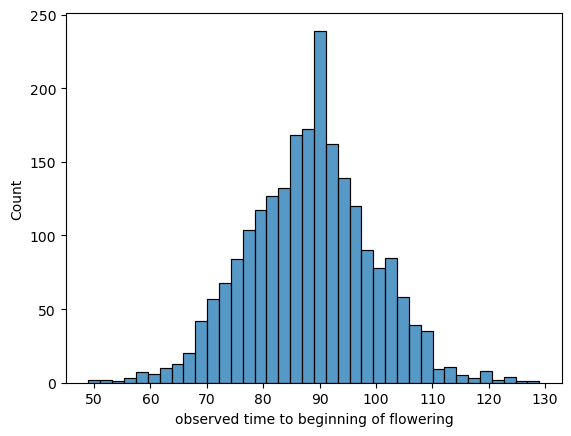

In [19]:
ds_inputs_DE['observed time to beginning of flowering']

In [92]:
ds_inputs_DE_mask = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_with_mask.csv')
ds_inputs_DE_mask.loc[:, [f't2m at day {n}' for n in range(200)]] = modelling_fctns.Wang_Engel_Temp_response(ds_inputs_DE_mask.loc[:, [f't2m at day {n}' for n in range(200)]], 7, 28, 42)
ds_inputs_DE_mask = make_cumulative(ds_inputs_DE_mask, driver_variable = 't2m', numdays = 200, T_base = 0)

ds_panel_DE_mask = convert_data_to_panel(ds_inputs_DE_mask)

ds_panel_DE_mask.loc[:, 'const'] = 1

In [46]:
R2s, Biases, Variances = KFold_crossval(ds_panel_DE, 5, predictors = ['NDVI', 'acc temp', 'photoperiod', 'time from SOS', 'const'])#.loc[(ds_panel_DE['year'] > 2000)*(ds_panel_DE['year'] < 2005)]'NDVI', 'acc temp', 'photoperiod', 'const'

66150
Optimization terminated successfully.
         Current function value: 0.089277
         Iterations 11
Fold: 1
R2: 0.5200139796241595
Bias: 0.17031997984378935
Variance: 64.33033395176263
66150
Optimization terminated successfully.
         Current function value: 0.088685
         Iterations 11
Fold: 2
R2: 0.5154371208611335
Bias: 1.059825895588772
Variance: 62.87737579880434
66150
Optimization terminated successfully.
         Current function value: 0.089541
         Iterations 11
Fold: 3
R2: 0.5375182023691034
Bias: 0.00018510805682817342
Variance: 61.92694289837168
66000
Optimization terminated successfully.
         Current function value: 0.089869
         Iterations 11
Fold: 4
R2: 0.5381709132177321
Bias: 0.9954597107438016
Variance: 63.50361876164836
66000
Optimization terminated successfully.
         Current function value: 0.091257
         Iterations 11
Fold: 5
R2: 0.5780443924398078
Bias: 0.06712809917355372
Variance: 60.064190308552476
Average score: 0.537836921702

In [51]:
R2s_RF, Biases_RF, Variances_RF = KFold_crossval_RF(ds_panel_DE, 5, predictors = ['NDVI', 'acc temp', 'photoperiod', 'time from SOS', 'const'])#.loc[(ds_panel_DE['year'] > 2000)*(ds_panel_DE['year'] < 2005)]'NDVI', 'acc temp', 'photoperiod', 'const'

Fold: 1
R2: 0.4929865326321876
Bias: 1.06918413623953
Variance: 63.53232323232315
Fold: 2
R2: 0.5167348939437006
Bias: 0.0993464657215872
Variance: 62.276077097505556
Fold: 3
R2: 0.49278125397263395
Bias: 0.5944025380371347
Variance: 66.23358070500925
Fold: 4
R2: 0.5025254154783666
Bias: 0.050625
Variance: 67.70883723338177
Fold: 5
R2: 0.5485893651401005
Bias: 0.9373760330578511
Variance: 60.824596189687355
Average score: 0.5107234922333979


In [46]:
np.mean(Biases)

0.458583758681349

In [37]:
R2s_nosat, Biases_nosat, Variances_nosat = KFold_crossval(ds_panel_SSA, 5, predictors = ['NDVI', 'photoperiod', 'acc temp', 'const'])

7360
Optimization terminated successfully.
         Current function value: 0.100019
         Iterations 10
Fold: 1
R2: 0.41171118976707965
Bias: 0.2084120982986767
Variance: 100.18599033816425
7360
Optimization terminated successfully.
         Current function value: 0.099982
         Iterations 10
Fold: 2
R2: 0.3284629558790806
Bias: 0.00047258979206049145
Variance: 114.0
7360
Optimization terminated successfully.
         Current function value: 0.111238
         Iterations 10
Fold: 3
R2: 0.5989043511628003
Bias: 0.12098298676748581
Variance: 94.49903381642511
7200
Optimization terminated successfully.
         Current function value: 0.107972
         Iterations 10
Fold: 4
R2: 0.3158930696695048
Bias: 0.8301234567901234
Variance: 85.24040404040403
7200
Optimization terminated successfully.
         Current function value: 0.108637
         Iterations 10
Fold: 5
R2: 0.5001797268152408
Bias: 0.02419753086419753
Variance: 88.9070707070707
Average score: 0.43103025865874117


In [43]:
np.mean(Biases_nosat)

0.23683773250250878

In [40]:
#train, test = train_test_on_statyear(ds_panel_DE2, train_proportion = 0.8)
log_reg = logit_reg(train, predictors = [f'NDVI at t minus {9 - t}' for t in range(5, 10)] + ['time from SOS', 'const']) #['NDVI', 'acc temp', 'photoperiod', 'time from SOS', 'const']
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.127224
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:              dev stage   No. Observations:               323700
Model:                          Logit   Df Residuals:                   323693
Method:                           MLE   Df Model:                            6
Date:                Thu, 12 Jun 2025   Pseudo R-squ.:                  0.8158
Time:                        16:10:26   Log-Likelihood:                -41182.
converged:                       True   LL-Null:                   -2.2354e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
NDVI at t minus 4    94.8352      7.109     13.340      0.000      80.901     108.769
NDVI at

In [63]:
test_for_regression, test = compare_logreg_test(test, log_reg, predictors = ['time from SOS', 't2m', 't2min', 't2max', 'vpd', 'tp', 'ssrd', 'photoperiod', 'const']) #['NDVI', 'acc temp', 'photoperiod', 'time from SOS', 'const']
#test_for_regression = compare_logreg_test(test, log_reg, predictors = ['NDVI', 'acc temp', 'photoperiod', 'time from SOS', 'const'])

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_20596\404752762.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xtest.loc[:, 'fitted'] = log_reg.predict(Xtest)#.round()
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_20596\404752762.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xtest.loc[:, 'observed'] = ytest


In [64]:
test['fitted'].min()

1.0

In [35]:
test['observed'] = test['dev stage']
test_for_regression = compare_logreg_test(test, log_reg, ['t2m', 't2min', 't2max', 'vpd', 'tp', 'ssrd', 'photoperiod', 'time from SOS', 'const']) #['NDVI', 'acc temp', 'photoperiod', 'time from SOS', 'const']


C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_4068\3332983046.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xtest.loc[:, 'fitted'] = log_reg.predict(Xtest).round()
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_4068\3332983046.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xtest.loc[:, 'observed'] = ytest


In [56]:
test_for_regression['observed'].max()

0.0

In [35]:
np.sqrt(((test_for_regression['fitted'] - test_for_regression['observed'])**2).mean())

7.708845818595368

In [58]:
(test_for_regression['fitted'] - test_for_regression['observed']).mean()**2

324.5558441847445

In [27]:
(8.69**2)/(11.5**2)

0.5710102079395085

In [55]:
test_for_regression['fitted'] = test_for_regression['fitted'] - test_for_regression['fitted'].mean()
test_for_regression['observed'] = test_for_regression['observed'] - test_for_regression['observed'].mean()

R2 score 0.41655881199158284


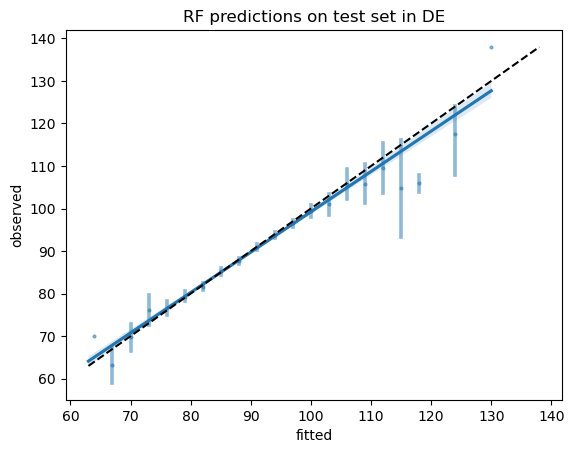

In [36]:
plot_fitted_observed(test_for_regression, 'RF predictions on test set in DE')

In [25]:
import torch.nn as nn
import torch

In [40]:
loss_func = nn.NLLLoss()
output = torch.swapaxes(torch.stack([torch.Tensor(test['fitted']), torch.Tensor(1 - test['fitted'])]), 0, 1)
loss_func(output, torch.Tensor(test['observed']).long()).item()

-0.04668327048420906

In [39]:
output.shape

torch.Size([2, 262422])

In [15]:
test_for_regression

fitted  observed
Stations_id year                    
7521.0      2018.0    98.0      95.0
            2019.0   107.0     105.0
            2020.0   113.0     107.0
            2022.0   110.0      99.0
7608.0      2019.0   102.0     102.0
...                    ...       ...
19585.0     2020.0   108.0     103.0
            2022.0   105.0     102.0
19700.0     2018.0    94.0     101.0
            2019.0   100.0     112.0
            2020.0   107.0     123.0

[1434 rows x 2 columns]

NameError: name 'comparison_frame' is not defined

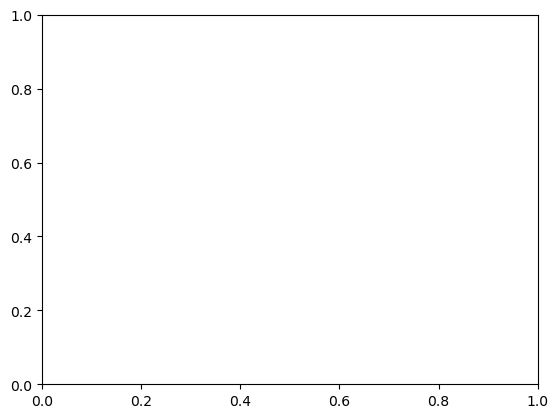

In [20]:
test_for_SSA, Xtest = compare_logreg_test(ds_panel_SSA.reset_index(), log_reg)

R2 score 0.05587869830011427


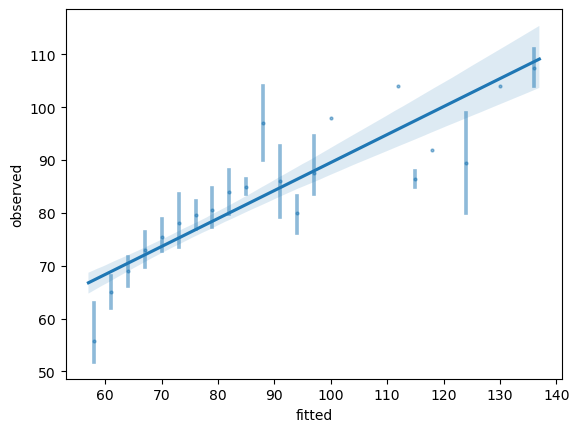

In [33]:
plot_fitted_observed(test_for_SSA)

In [20]:
(test_for_SSA['fitted'] - test_for_SSA['observed']).min()

-62.0

In [199]:
plot_fitted_observed(test_for_SSA)

ValueError: attempt to get argmin of an empty sequence

In [174]:
Xtest = test[['NDVI', 'acc temp', 'photoperiod', 'const']]
ytest = test[['dev stage']]
    
yhat = log_reg.predict(Xtest)
prediction = list(map(round, yhat))

# comparing original and predicted values of y
print('Actual values', list(ytest.values.squeeze()))
print('Predictions :', prediction)

Actual values [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

In [175]:
with warnings.catch_warnings(action="ignore"):
    Xtest.loc[:, 'fitted'] = log_reg.predict(Xtest).round()
    Xtest.loc[:, 'observed'] = ytest

In [46]:
Xtrain = ds_panel_DE[['NDVI', 'acc temp', 'photoperiod']]
ytrain = ds_panel_DE[['dev stage']]
 
# building the model and fitting the data
log_reg = sm.Logit(ytrain, Xtrain).fit()

Optimization terminated successfully.
         Current function value: 0.088185
         Iterations 10
